In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
df = pd.read_parquet("/home/joaquino/portuguese-llm/data/merged_data_sentiment.parquet").dropna(thresh=2)

In [3]:
df.columns

Index(['messageId', 'message', 'trait', 'original_prompt', 'model', 'response',
       'responseId', 'udpipe_result', 'MLC', 'MLS', 'DCC', 'CPC',
       'profundidade_media', 'profundidade_max', 'ttr', 'lexical_density',
       'token_quantity', 'adjective_list', 'substantive_list', 'genero',
       'raca', 'regiao', 'localidade', 'unused', 'artigo', 'pronome',
       'response_lemm', 'sentiment_label', 'sentiment_score',
       'sentiment_normalized'],
      dtype='object')

In [4]:
metrics = ['MLC', 'MLS', 'DCC', 'CPC', 'profundidade_media',
       'profundidade_max', 'ttr', 'lexical_density', 'token_quantity']

# Create a mapping for better metric names
metrics_mapping = {
    'MLC': 'MLC',
    'MLS': 'MLS', 
    'DCC': 'DCC',
    'CPC': 'CPC',
    'profundidade_media': 'Avg Depth',
    'profundidade_max': 'Max Depth',
    'ttr': 'Type-Token Ratio',
    'lexical_density': 'Lexical Density',
    'token_quantity': 'Token Quantity'
}

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
def remove_outliers(df, column):
    """
    Remove outliers from the DataFrame based on the IQR method.
    
    Parameters:
    df (DataFrame): The DataFrame from which to remove outliers.
    column (str): The column name for which to remove outliers.
    
    Returns:
    DataFrame: The DataFrame with outliers removed.
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [7]:
col = "model"

In [8]:
df_non_empty = df[df["response"].str.len() > 0]

In [13]:
import umap
from sklearn.preprocessing import StandardScaler

#using metrics, use UMAP and show the model column
# Extract the metrics columns for UMAP
X = df_non_empty[metrics].values
# Standardize the data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform UMAP
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
X_embedded = reducer.fit_transform(X_scaled)

/home/joaquino/miniconda3/envs/poc_2/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


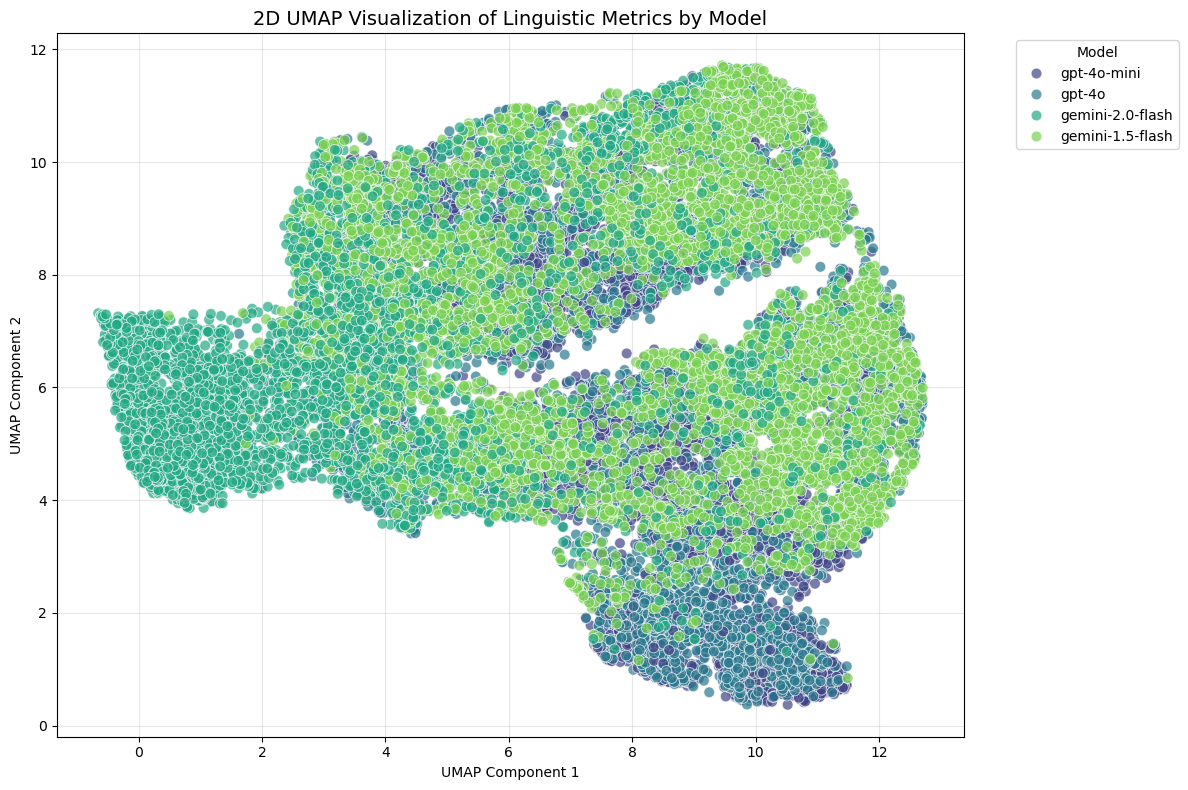

In [14]:
# Create a 2D scatter plot using UMAP components
plt.figure(figsize=(12, 8))

# Plot using seaborn for better styling
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=df_non_empty[col], 
                palette='viridis', alpha=0.7, s=60)

plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('2D UMAP Visualization of Linguistic Metrics by Model', fontsize=14)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

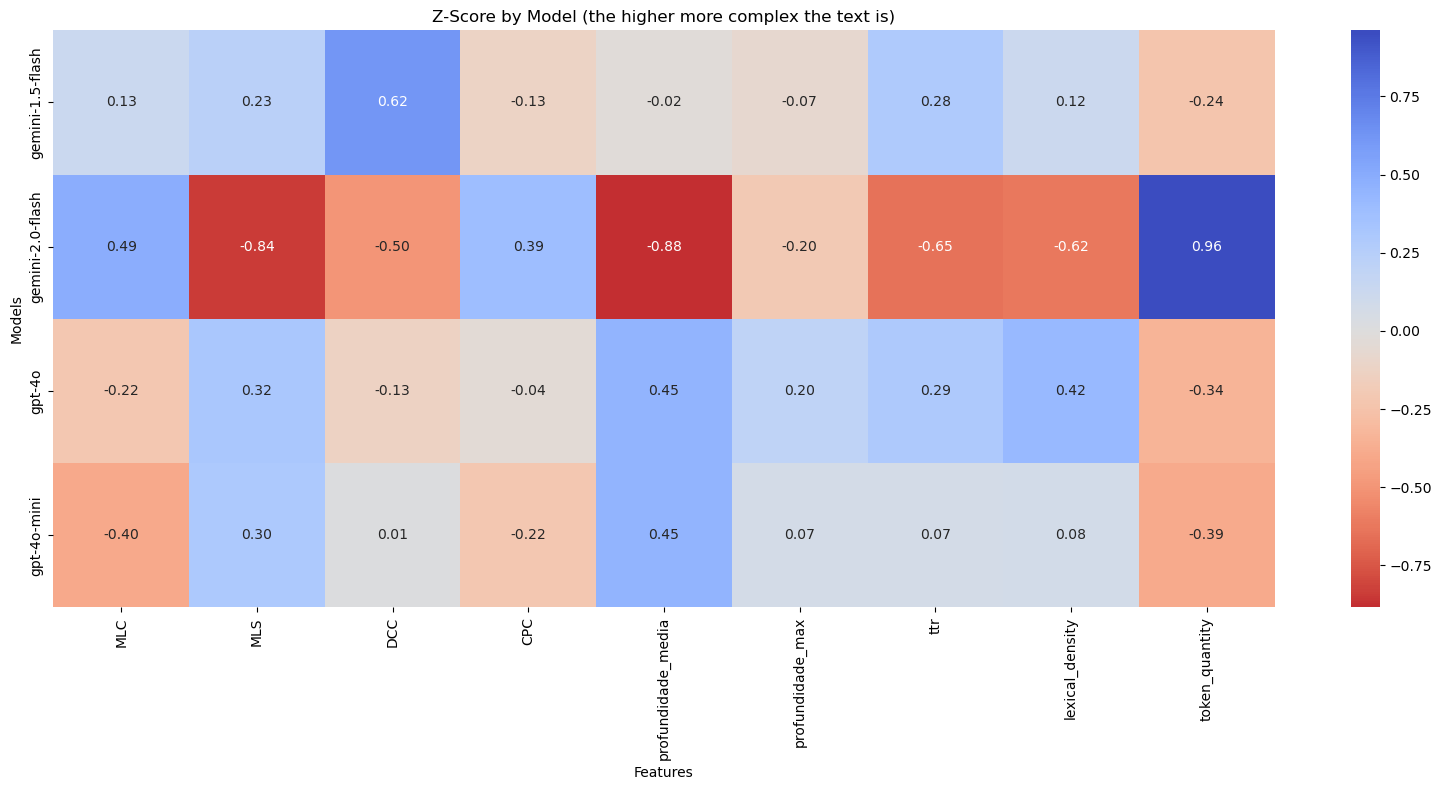

In [11]:
# Normalize the features using z-score and show a heatmap features by model
# Normalize the features using z-score for the entire dataset
X_scaled_model = (df[metrics] - df[metrics].mean()) / df[metrics].std()
z_scores_model = pd.DataFrame(X_scaled_model, columns=metrics)

# Add the model column to the z-scores DataFrame
z_scores_model['model'] = df['model'].values

# Create a pivot table to calculate the mean z-scores for each model
z_scores_model_pivot = z_scores_model.groupby('model').mean()

# Plot a heatmap of the normalized features by model
plt.figure(figsize=(16, 8))
sns.heatmap(z_scores_model_pivot, annot=True, cmap='coolwarm_r', center=0, fmt='.2f')
plt.title('Z-Score by Model (the higher more complex the text is)')
plt.xlabel('Features')
plt.ylabel('Models')
plt.tight_layout()
plt.savefig("zscore_heatmap.pdf", bbox_inches="tight")
plt.show()

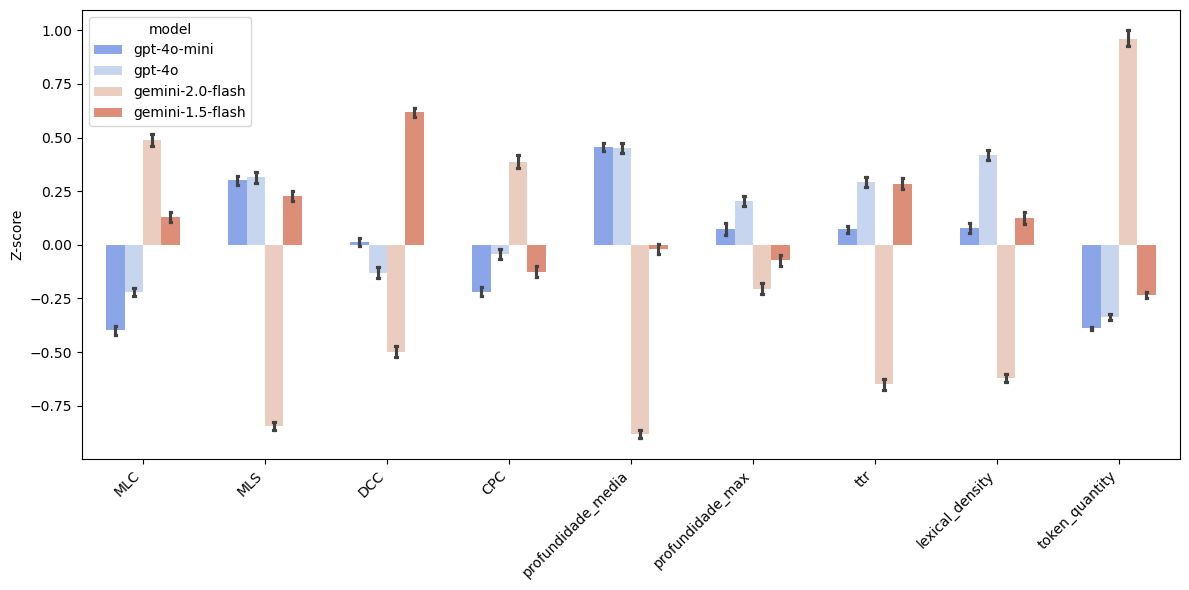

In [12]:
z_scores = df_non_empty[metrics].apply(lambda x: (x - x.mean()) / x.std())
z_scores["model"] = df_non_empty["model"]
z_scores_melted  = z_scores.melt(id_vars="model", var_name="variable", value_name="z_score")
plt.figure(figsize=(12, 6))

custom_palette = ["#A0B4EB","#B0A4EB", "#BDCBF1", "#DBA38D", "#DBA38D"]  # Example colors
# sns.set_palette(sns.color_palette(custom_palette))
sns.barplot(data=z_scores_melted, x="variable", y="z_score", hue="model", 
            palette="coolwarm",
            # hue_order=hue_order,
            errorbar="ci", capsize=.05,
            width=0.6)
plt.xlabel("")
plt.ylabel("Z-score")
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()